<a href="https://colab.research.google.com/github/thiagomelostuckert/datathon-fakenews/blob/main/2_Modelos_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construção de dois modelos de aprendizado de máquinas que automatizem a detecção de notícias falsas

A etapa seguinte, a ser tocada pelo cientista de dados, envolve o treinamento do modelo. Já tendo em mãos a base de dados de treino preparada pelo analista de dados, o cientista de dados deverá desenvolver pelo menos dois modelos (note que a escolha do modelo pode implicar mudança no tratamento prévio da base de dados), considerando diferentes cenários de inferência.
O cientista de dados deverá considerar dois cenários para inferência para definição dos modelos: batch (quando há uma série de notícias a serem avaliadas simultaneamente) e streaming (uma notícia por vez, em tempo real). Deverá haver justificativa para a escolha de cada modelo para as diferentes finalidades possíveis nas atividades de inteligência, e também devem constar as estatísticas de treino (report de classificação, matriz de confusão, etc.)
Finalmente, o cientista de dados deverá salvar os parâmetros do modelo treinado considerando inferência em streaming no formato ‘pickle’, que será utilizado na próxima etapa.
Recomenda-se utilizar as bibliotecas mais consolidadas para machine learning, como sklearn, tensorflow e pytorch. Não é necessário desenvolver soluções que envolvam poder computacional que exceda a capacidade do Google Colab gratuito.
A avaliação se dará com a performance dos modelos (não disponibilizamos parte da base de dados para verificar o poder de generalização dos modelos); eficiência de código; escolha de cada modelo para qual finalidade.

Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# Modelos das abordagens clássicas
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Modelo usando rede neural
from sklearn.neural_network import MLPClassifier

# Bibliotecas utilizadas para calcular as métricas dos modelos
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef
from datetime import datetime


sns.set()

#Utilizados na hora de carregar o arquivo com a matriz TF-IDF
import gzip
import pickle

import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

Leitura dos arquivos de entrada para os modelos

In [2]:
#Leitura dos textos
url_textos = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_data.csv"
df_textos = pd.read_csv(url_textos, on_bad_lines = 'warn')

In [3]:
# Carrega a matriz TF-IDF calculada anteriormente
!wget "https://github.com/thiagomelostuckert/datathon-fakenews/raw/main/matrix-tf-idf.pkl"

with gzip.open('/content/matrix-tf-idf.pkl', 'rb') as f:
    X = pickle.load(f)

print(X.toarray())
print(X.shape)

--2023-12-02 09:12:53--  https://github.com/thiagomelostuckert/datathon-fakenews/raw/main/matrix-tf-idf.pkl
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/matrix-tf-idf.pkl [following]
--2023-12-02 09:12:53--  https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/matrix-tf-idf.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13076603 (12M) [application/octet-stream]
Saving to: ‘matrix-tf-idf.pkl’

matrix-tf-idf.pkl   100%[===================>]  12.47M  --.-KB/s    in 0.04s   

2023-12-02 09:12:54 (317 MB/s) - ‘matrix-tf-idf.

In [4]:
#Leitura das classificações
url_classificacoes = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_labels.csv"
df_classificacoes = pd.read_csv(url_classificacoes, on_bad_lines = 'warn')

In [5]:
#Junta os dois datasets em um único dataframe
df = pd.merge(df_textos, df_classificacoes, left_index=True, right_index=True)
df.columns

Index(['preprocessed_news', 'label'], dtype='object')

In [6]:
# Questionar aos organizadores do Datathon se podemos utilizar o arquivo
# pré-processado do repositório do professor como conjunto de dados para testes dos modelos
#Leitura dos textos utilizados no teste
#url_test_data = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/pre-processed.csv"
#df_test_data = pd.read_csv(url_test_data, on_bad_lines = 'warn')
#df_test_data = df_test_data.drop("index",axis=1)

In [7]:
# Treina o modelo e apresenta suas métricas
# Parâmetro X corresponde aos textos e y às classificações
def fit_and_evaluate_model(model,model_name,X,y):
  # Divide o dataset em treinamento (67%) e teste (33%)
  X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42)

  #Captura o timestamp antes de começar o fit para calcular o tempo de treinamento
  t0 = datetime.now()
  # Treina o modelo com os textos e suas classificações
  model.fit(X_train, y_train)

  #Captura o timestamp após o treinamento
  t1 = datetime.now()

  #Tempo de treinamento em segundos
  tt = (t1 - t0).total_seconds()


  #Faz a predição dos textos da base de testes com o modelo Naive Bayes
  predicted_labels = model.predict(X_test)

  #Captura o tempo após o teste para calcular o tempo de classificação
  t2 = datetime.now()

  #Tempo de classificação em segundos
  tc = (t2 - t1).total_seconds()

  #salva o modelo em um arquivo no formato pickle
  file_name = model_name+'.pkl'
  try:
    with open(file_name, 'wb') as f:
      pickle.dump(model, f)
      print(f"Salvou o arquivo com o modelo treinado:{file_name}")
  except:
      print(f"Falha ao salvar o modelo treinado:{file_name}")

  # Análise da eficiência do modelo
  # Matriz de confusão
  conf_mat = confusion_matrix(y_test, predicted_labels,labels=["fake","true"],  normalize="true")
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
  disp.plot()
  plt.show()

  #Extração dos valores da matriz de confusão
  tn, fp, fn, tp = conf_mat.ravel()

  # Imprime outras métricas
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  accuracy_value = accuracy_score(y_test, predicted_labels)
  print("Acurácia: {:.3f}".format(accuracy_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
  f1_value = f1_score(y_test, predicted_labels, average='macro')
  print("F1-Score: {:.3f}".format(f1_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
  precision_value = precision_score(y_test, predicted_labels, average='macro')
  print("Precisão: {:.3f}".format(precision_value))

  #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
  recall_value = recall_score(y_test, predicted_labels, average='macro')
  print("Recall (cobertura): {:.3f}".format(recall_value))

  print("Tempo de treinamento (s): {:.3f}".format(tt))

  print("Tempo de classificação (s): {:.3f}".format(tc))

  print("Verdadeiro Positivo (TP): {:.3f}".format(tp))
  print("Verdadeiro Negativo (TN): {:.3f}".format(tn))
  print("Falso Positivo (FP): {:.3f}".format(fp))
  print("Falso Negativo (FN): {:.3f}".format(fn))

  evalution_metric = {"Model":model_name, "ACC":accuracy_value, "F1":f1_value, "PRE":precision_value,
          "REC":recall_value, "TT(s)":tt, "TC(s)":tc, "TP":tp, "TN":tn,"FP":fp,"FN":fn}

  return evalution_metric


Significado das células da matriz de confusão

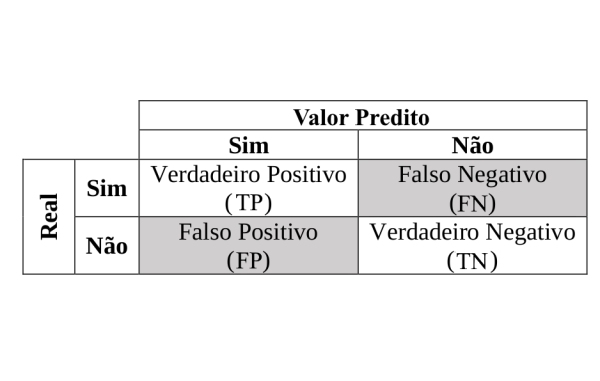

In [8]:
# Lista utilizada para armazenar as métricas obtidas em cada classificador
evaluation_metrics = []

In [9]:
# Imprime as métricas dos classificadores para facilitar a comparação
def print_evaluation_metrics(evaluation_metrics):
  if len(evaluation_metrics) == 0:
    print("Sem métricas registradas, favor rodar as células dos classificadores que se deseja comparar.")
    return

  for key in evaluation_metrics[0].keys():
    print(key,end='\t')

  print()
  for evaluation_metric in evaluation_metrics:
    for key, value in evaluation_metric.items():
      if type(value) == str:
        print(value,end='\t')
      else:
        print("{:.3f}".format(value),end='\t')
    print()

  print("\nLegenda:")
  print("NB1 = Naive Bayes utilizando a matriz TF-IDF calculada anteriormente")
  print("NB2 = Naive Bayes Calculando a matriz TF-IDF durante o pipeline de treinamento do modelo")
  print("LR = Logistic Regression")
  print("SVC = Linear Support Vector Classification")
  print("RFC = RandomForestClassifier")
  print("MLP = Multi-layer Perceptron classifier")
  print("ACC = Acurácia")
  print("F1 = F1-Score")
  print("PRE = Precisão")
  print("REC = Recall (Cobertura)")
  print("TT = Tempo de treinamento (segundos)")
  print("TC = Tempo de classificação (segundos)")
  print("TP = Verdadeiro Positivo")
  print("TN = Verdadeiro Negativo")
  print("FP = Falso Positivo")
  print("FN = Falso Negativo")

### Abordagens clássicas

Naive Bayes

Referências:
https://www.turing.com/kb/document-classification-using-naive-bayes

https://towardsdatascience.com/implementing-a-naive-bayes-classifier-for-text-categorization-in-five-steps-f9192cdd54c3

MultinomialNB é um classificador Naive Bayes
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html



Salvou o arquivo com o modelo treinado:NB1.pkl


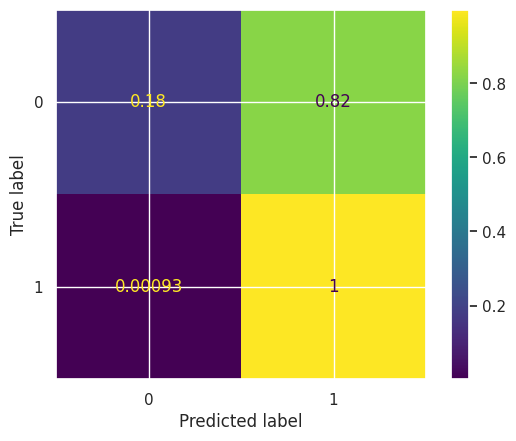

Acurácia: 0.589
F1-Score: 0.505
Precisão: 0.772
Recall (cobertura): 0.588
Tempo de treinamento (s): 0.048
Tempo de classificação (s): 0.006
Verdadeiro Positivo (TP): 0.999
Verdadeiro Negativo (TN): 0.178
Falso Positivo (FP): 0.822
Falso Negativo (FN): 0.001


In [10]:
# Construção de uma modelo clássico usando Naive Bayes
# Utilizando a matriz TF-IDF calculada anteriormente
model = make_pipeline(MultinomialNB())
model_name="NB1"
evaluation_metric = fit_and_evaluate_model(model,model_name,X, df.label)
evaluation_metrics.append(evaluation_metric)

Salvou o arquivo com o modelo treinado:NB2.pkl


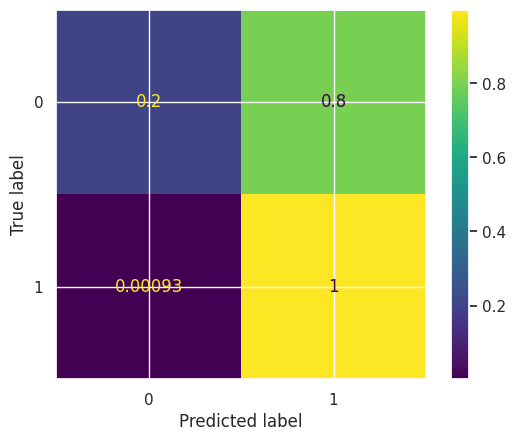

Acurácia: 0.602
F1-Score: 0.528
Precisão: 0.776
Recall (cobertura): 0.602
Tempo de treinamento (s): 2.332
Tempo de classificação (s): 0.792
Verdadeiro Positivo (TP): 0.999
Verdadeiro Negativo (TN): 0.205
Falso Positivo (FP): 0.795
Falso Negativo (FN): 0.001


In [11]:
# Construção de uma modelo clássico usando Naive Bayes
# Calculando a matriz TF-IDF durante o pipeline do modelo
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_name="NB2"
evaluation_metric = fit_and_evaluate_model(model,model_name, df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

Regressão logística

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
*italicized text*

Salvou o arquivo com o modelo treinado:LR.pkl


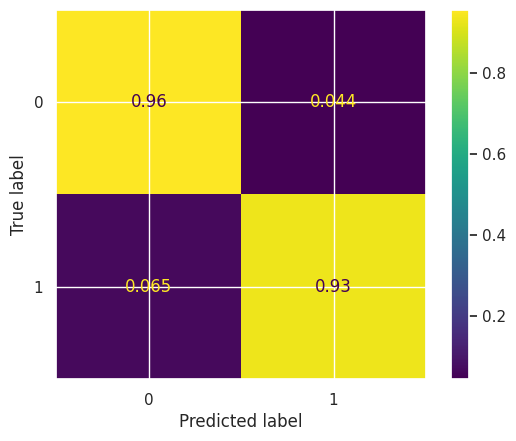

Acurácia: 0.945
F1-Score: 0.945
Precisão: 0.946
Recall (cobertura): 0.945
Tempo de treinamento (s): 6.469
Tempo de classificação (s): 4.165
Verdadeiro Positivo (TP): 0.935
Verdadeiro Negativo (TN): 0.956
Falso Positivo (FP): 0.044
Falso Negativo (FN): 0.065


In [ ]:
# Construção de uma modelo clássico usando Regressão logística
model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model_name="LR"
evaluation_metric = fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

Linear Support Vector Classification

Referências:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


Salvou o arquivo com o modelo treinado:SVC.pkl


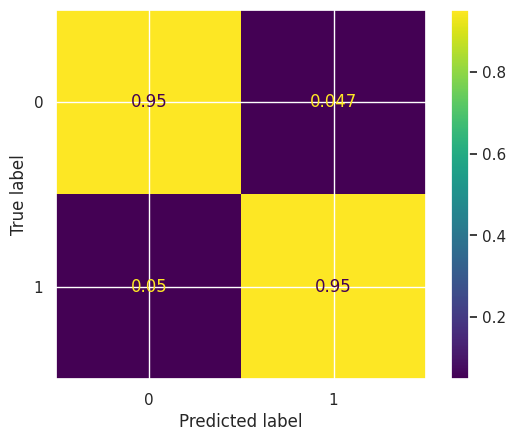

Acurácia: 0.952
F1-Score: 0.952
Precisão: 0.952
Recall (cobertura): 0.952
Tempo de treinamento (s): 3.580
Tempo de classificação (s): 0.831
Verdadeiro Positivo (TP): 0.950
Verdadeiro Negativo (TN): 0.953
Falso Positivo (FP): 0.047
Falso Negativo (FN): 0.050


In [ ]:
# Construção de uma modelo clássico usando Linear Support Vector Classification
model = make_pipeline(TfidfVectorizer(), LinearSVC())
model_name = "SVC"
evaluation_metric = fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

A random forest classifier.

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html



Salvou o arquivo com o modelo treinado:RFC.pkl


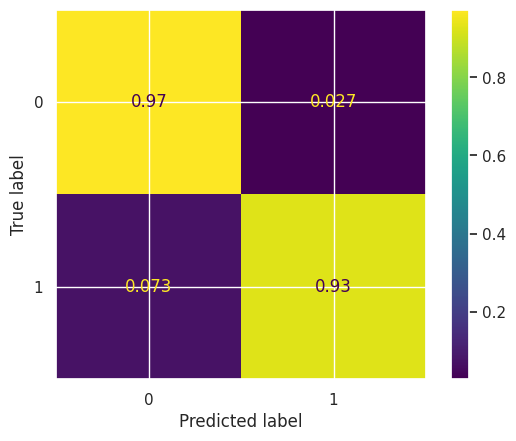

Acurácia: 0.950
F1-Score: 0.950
Precisão: 0.951
Recall (cobertura): 0.950
Tempo de treinamento (s): 9.557
Tempo de classificação (s): 1.011
Verdadeiro Positivo (TP): 0.927
Verdadeiro Negativo (TN): 0.973
Falso Positivo (FP): 0.027
Falso Negativo (FN): 0.073


In [ ]:
# Construção de uma modelo clássico usando RandomForestClassifier
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
model_name = "RFC"
evaluation_metric = fit_and_evaluate_model(model,model_name, df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

In [ ]:
print_evaluation_metrics(evaluation_metrics)

Model	ACC	F1	PRE	REC	TT(s)	TC(s)	TP	TN	FP	FN	
NB1	0.589	0.505	0.772	0.588	0.065	0.010	0.999	0.178	0.822	0.001	
NB2	0.602	0.528	0.776	0.602	3.925	1.791	0.999	0.205	0.795	0.001	
LR	0.945	0.945	0.946	0.945	6.469	4.165	0.935	0.956	0.044	0.065	
SVC	0.952	0.952	0.952	0.952	3.580	0.831	0.950	0.953	0.047	0.050	
RFC	0.950	0.950	0.951	0.950	9.557	1.011	0.927	0.973	0.027	0.073	

Legenda:
NB1 = Naive Bayes utilizando a matriz TF-IDF calculada anteriormente
NB2 = Naive Bayes Calculando a matriz TF-IDF durante o pipeline de treinamento do modelo
LR = Logistic Regression
SVC = Linear Support Vector Classification
RFC = RandomForestClassifier
MLP = Multi-layer Perceptron classifier
ACC = Acurácia
F1 = F1-Score
PRE = Precisão
REC = Recall (Cobertura)
TT = Tempo de treinamento (segundos)
TC = Tempo de classificação (segundos)
TP = Verdadeiro Positivo
TN = Verdadeiro Negativo
FP = Falso Positivo
FN = Falso Negativo


# Abordagem usando rede neural
Multi-layer Perceptron classifier

Referências: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html


CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 8.34 µs
Salvou o arquivo com o modelo treinado:MLP.pkl


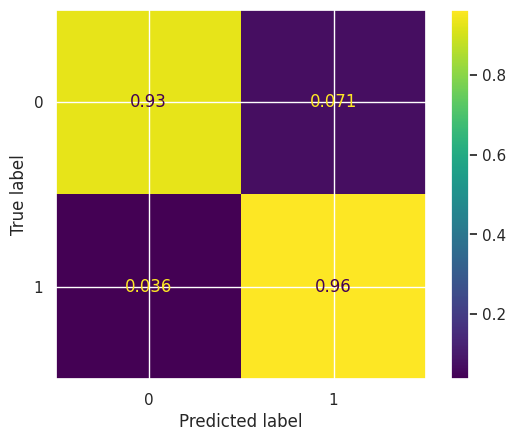

Acurácia: 0.946
F1-Score: 0.946
Precisão: 0.947
Recall (cobertura): 0.946
Tempo de treinamento (s): 390.015
Tempo de classificação (s): 0.898
Verdadeiro Positivo (TP): 0.964
Verdadeiro Negativo (TN): 0.929
Falso Positivo (FP): 0.071
Falso Negativo (FN): 0.036


In [ ]:
%time
# Atenção essa célula demora para rodar
# Construção de uma modelo clássico usando Multi-layer Perceptron classifier
model = make_pipeline(TfidfVectorizer(), MLPClassifier())
model_name = "MLP"
evaluation_metric = fit_and_evaluate_model(model,model_name,df.preprocessed_news, df.label)
evaluation_metrics.append(evaluation_metric)

In [ ]:
print_evaluation_metrics(evaluation_metrics)

Model	ACC	F1	PRE	REC	TT(s)	TC(s)	TP	TN	FP	FN	
NB1	0.589	0.505	0.772	0.588	0.065	0.010	0.999	0.178	0.822	0.001	
NB2	0.602	0.528	0.776	0.602	3.925	1.791	0.999	0.205	0.795	0.001	
LR	0.945	0.945	0.946	0.945	6.469	4.165	0.935	0.956	0.044	0.065	
SVC	0.952	0.952	0.952	0.952	3.580	0.831	0.950	0.953	0.047	0.050	
RFC	0.950	0.950	0.951	0.950	9.557	1.011	0.927	0.973	0.027	0.073	
MLP	0.946	0.946	0.947	0.946	390.015	0.898	0.964	0.929	0.071	0.036	

Legenda:
NB1 = Naive Bayes utilizando a matriz TF-IDF calculada anteriormente
NB2 = Naive Bayes Calculando a matriz TF-IDF durante o pipeline de treinamento do modelo
LR = Logistic Regression
SVC = Linear Support Vector Classification
RFC = RandomForestClassifier
MLP = Multi-layer Perceptron classifier
ACC = Acurácia
F1 = F1-Score
PRE = Precisão
REC = Recall (Cobertura)
TT = Tempo de treinamento (segundos)
TC = Tempo de classificação (segundos)
TP = Verdadeiro Positivo
TN = Verdadeiro Negativo
FP = Falso Positivo
FN = Falso Negativo


Modelo Batch (quando há uma série de notícias a serem avaliadas simultaneamente)

Model streaming (uma notícia por vez, em tempo real)

Salvar os parâmetros do modelo treinado considerando inferência em streaming no formato ‘pickle’

In [ ]:
# Observação: estou salvando o modelo treinado dentro da função "fit_and_evaluate_model"

def classifica_novo_texto(model_name, new_text):
  #Carrega o modelo treinado
  file_name = model_name+'.pkl'
  file_path="/content/"+file_name
  try:
    with open(file_path, 'rb') as f:
      model = pickle.load(f)
      #print(f"Carregou o modelo treinado: {file_path}")
      #Classifica o novo texto com o modelo
      classificacao = model.predict(new_text)
      print(classificacao)
  except Exception as error:
    print("Falha ao carregar o modelo treinado.")
    print(f"Exceção: {error} ")


In [ ]:
new_text = ["guta oriental entenda regiao siria sob intenso ataque chegou crise humanitaria regiao proxima damasco sitiada desde alvo intensos bombardeios regime sirio mortos ataques desde domingo passam nesta semana regiao arredores damasco siria chamou atencao noticiario internacional ser palco sangrentos bombardeios resultaram mortes civis apenas horas guta oriental antigo destino viagens final semana moradores capital siria atualmente ultimos redutos rebeldes lutam contra regime ditador bashar nesta regiao cerca quilometros quadrados mil pessoas vivem cercados forcas cerco guta oriental inicio dois anos explodir guerra siria balanco vitimas segunda maior ja registrado horas desde ano regiao alvo ataque quimico apesar ser isolada bombardeada ha anos desde dia fevereiro guta oriental alvo nova campanha aerea lancada regime assad aliado russia desde entao civis morreram bombardeios diarios segundo estimativa observatorio sirio direitos humanos osdh mortos ha criancas dia bombardeios retomados tropas chegaram regiao reforcar cerco preparar ofensiva terrestre ainda nao inicio parece forcas sirias russas tentam retomar territorio controle rebeldes qualquer custo neste sabado conselho seguranca onu aprovou unanimidade resolucao pede dias regiao objetivo facilitar chegada ajuda humanitaria resgate feridos aliada assad russia concordou resolucao apos exigir mudancas teor texto veja seguir principais pontos explicam acontecendo guta oriental guta nome informal usado referir suburbios damasco ficam entorno rio barada antes guerra guta regiao agricola produtora vegetais frutas incluindo damasco ja maior fornecedor arroz acucar frutas vegetais capital tambem considerado pulmao verde onde habitantes capital passavam final semana residentes guta oriental primeiros rebelar contra regime assad regiao tomada rebeldes ano agitacao tornou conflito armado repressao manifestacoes sangrenta guerra civil julho opositores partiram luta armada formaram exercito sirio livre esl lancaram partir guta batalha contra damasco partir dessa regiao rebeldes lancam projeteis contra bairros damasco atualmente tres grupos principais lutam guta oriental piores ataques guerra civil siria ocorreu contra regiao foguetes contendo gas sarin lancados contra area segundo comprovou tarde onu organizacao proibicao armas quimicas opaq ataque deixou mortos ultimas semanas governo assad voltou ser acusado lancar varios ataques quimicos guta oriental nega janeiro osdh relatou casos asfixia cidade duma moradores fontes medicas falando ataque gas cloro janeiro ataque semelhante aconteceu arredores duma acordo osdh falou sete casos asfixia fevereiro embaixadora estados unidos nacoes unidas nikki haley disse havia evidencias claras confirmar uso cloro ataques leste ghuta constantes bombardeios aereos fogo artilharia alem deixar muitas vitimas civis destruiram edificios residenciais mercados escolas hospitais cerco regiao provocou aumento precos escassez commodities consequentemente gerou falta alimentos fome desnutricao crise humanitaria comboios humanitarios onu raramente conseguem entrar regiao onu condenou privacao deliberada alimentos civis tatica guerra apos publicacao fotografias chocantes criancas esqueleticas leste guta fundo nacoes unidas infancia unicef denunciou pior crise desnutricao desde inicio guerra criancas menores cinco anos sofrendo desnutricao grave contra janeiro apesar proximidade regiao damasco forcas assad negligenciaram guta oriental durante primeiros anos guerra civil porque concentraram recuperar areas consideradas cruciais sobrevivencia governo homs aleppo regioes proximas fronteira libano assim grupos atuam regiao anos acumular grande reserva armas municoes vinham rotas abastecimento deserto siria tambem tempo suficiente construir tuneis subterraneos secretos protegem ataques aereos militantes ainda conseguiram cultivar proprios alimentos"]
classifica_novo_texto("SVC", new_text)

['true']


In [ ]:
new_text = ["saiba sao senadores votaram favor aecio neves aecio livre leve solto podera retomar mandato alem escapar recolhimento noturno determinado primeira turma stf verdade tudo nao passou grande acordo nacional stf senado tudo votos favoraveis senador contrarios"]
classifica_novo_texto("RFC", new_text)

['fake']


# BERT

Referências:

https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://arxiv.org/abs/1810.04805

In [37]:
def load_texts(url):
    df = pd.read_csv(url)
    texts = df['preprocessed_news'].tolist()
    return texts

In [38]:
def load_labels(url):
    df = pd.read_csv(url)
    labels = [1 if label == "true" else 0 for label in df['label'].tolist()]
    return labels

In [39]:
url = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_labels.csv"
labels =  load_labels(url)

In [40]:
url = "https://raw.githubusercontent.com/thiagomelostuckert/datathon-fakenews/main/train_data.csv"
texts = load_texts(url)

In [42]:
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length
  def __len__(self):
    return len(self.texts)
  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [43]:
class BERTClassifier(nn.Module):
  def __init__(self, bert_model_name, num_classes):
    super(BERTClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits

In [44]:
def train(model, data_loader, optimizer, scheduler, device):
  model.train()
  for batch in data_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

In [45]:
def evaluate(model, data_loader, device):
  model.eval()
  predictions = []
  actual_labels = []
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      predictions.extend(preds.cpu().tolist())
      actual_labels.extend(labels.cpu().tolist())
  return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [46]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
  model.eval()
  encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
  input_ids = encoding['input_ids'].to(device)
  attention_mask = encoding['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
  return "true" if preds.item() == 1 else "fake"

In [47]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [48]:
#já separei em treinamento e teste. Verificar se é necessário fazer de novo
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [49]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [51]:
#Pendente procurar uma alternativa para o Adamw
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [52]:
for epoch in range(num_epochs):
  print(f"Epoch {epoch + 1}/{num_epochs}")
  train(model, train_dataloader, optimizer, scheduler, device)
  accuracy, report = evaluate(model, val_dataloader, device)
  print(f"Validation Accuracy: {accuracy:.4f}")
  print(report)

Epoch 1/4
Validation Accuracy: 0.8364
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       641
           1       0.80      0.91      0.85       655

    accuracy                           0.84      1296
   macro avg       0.84      0.84      0.84      1296
weighted avg       0.84      0.84      0.84      1296

Epoch 2/4
Validation Accuracy: 0.8858
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       641
           1       0.90      0.88      0.89       655

    accuracy                           0.89      1296
   macro avg       0.89      0.89      0.89      1296
weighted avg       0.89      0.89      0.89      1296

Epoch 3/4
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       641
           1       0.87      0.93      0.90       655

    accuracy                           0.90      1296
   macro avg  

In [53]:
torch.save(model.state_dict(), "bert_classifier.pth")


In [57]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)
model.load_state_dict(torch.load("/content/bert_classifier.pth"))
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [58]:
# Test sentiment prediction
test_text = "sinal tres poderes republica nao temem possibilidade punicao boca urna dado dias deste mes congresso nacional criou fundo financiamento campanha fazendo unica concessao trocar insultada democracia descricao factual objetivo dinheiro farto melhor piso teto bancar certamente bilionarias campanhas eleitorais dinheiro tungado contribuinte mesma ocasiao turma reunida abrigo cumbuca virada tigela emborcada concedeu membros merce pegar dinheiro emprestado cofres viuva comprometer pagar nao quer dizer pagarao dividas uniao conjunto espoliado povo brasileiro logo seguida votacao decidida voto coluna meio presidente belas frases vazias supremo tribunal federal stf carmen lucia judiciario devolveu nada insignes tambem nada insignificantes parlamentares poder tornarem foro superprivilegio intocaveis antes disso executivo alto poder monarquico havia recorrido expedientes rotina garantir imunidade pe meio chefe concluido processo esvaziamento cofres todos receptaculos suado amarfanhado dinheiro escorchado contribuintes parte sobrou saque promovido dois aliados antanho luiz inacio lula silva dilma janete vana rousseff linhares comprar discricao zero apoio terco deputados federais permaneca poder nao trata claro algo inusitado sequer original pratica vem tempos idos certamente sera repetida dias ainda nao vividos governos todas origens regimes todas confissoes fe ideologica sempre nunca sao aceitaveis sob nenhum ponto vista contemple nao apenas civismo comum manifestacoes honestidade pessoal governante compra votos congressista age forma perversa maligna democracia faziam coroneis guarda nacional imperio republica velha pratica malsa eleicoes bico pena sempre distorcao fatal democracia demanda recursos saliva poderosos momento paulo bonifacio jose tamm andrada ambos deputados aprisco senador aecio neto tancredo neves ministro justica governo democratico gege vargas golpe parlamentarista canonizado povo encarregou conduzir nova republica longa folha corrida bons servicos prestados poderosos ocasiao relator primeira denuncia rodrigo janot contra temer exemplo tambem nesta novissima republica nacional sai nao regenera filho ibrahim ministro justica plena vigencia republica injustica posta servico tecnocratas militares deputado tucano mineiro nao fez rogado encarregado produzir relatorio alternativo substituir peemedebista contra sergio zveiter bonifacio xara aparentado patriarca independencia sempre candidato ilustre brasileiro todos tempos nunca negou votar contra povo democracia longeva passagem camara deputados ajudou derrotar emenda dante oliveira restabeleceria eleicoes diretas presidente preferiu paulo maluf hoje fiel aliado temer antes ja lula tancredo colegio eleitoral sempre sombra sim nobre parente cuja fotografia orna gabinete cujo exemplo nao honrado desempenhoi parlamentar desonra alias nao limita aspectos politicos eticos relatorio documento altura libelo acusatorio inepto insolito republica rodrigo janot tambem originario alterosas inepcia acusacao defesa travestida relatorio contudo nada ver derrota sempre dada liquida certa segunda tentativa denuncia contra presidente republica organizacao criminosa obstrucao justica margem votos favor morador jaburu ocupante planalto exclusivamente manobras manutencao mandato chefe governo qualquer custo banquetes palacio casa leais aliados distribuicao cargos benesses cumprimento obrigacao legal pagamento emendas orcamentarias vez usados nao porque habito cachimbo entorta boca principalmente porque meio eficaz levar rapidamente mao boca comer consentir desta vez contudo historia sera mal contada nao contiver novos elementos vice dilma posto ascendeu nunca usurpou garantem antigos aliados nele votaram hoje chamam golpista acrescentou rica casos pobre meritos historia celebracao malfeitos nome democracia brasil hoje ha bens vem mal distorcao bons ditos sabedoria popular responsaveis maior orgulho producao nacional agroindustria corretamente comparada galinha ovos ouro chiqueiro povoado gambas ta"
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(f"Classificação obtida: {sentiment}")

Classificação obtida: true


BiLSTM

Referência:
https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/


In [ ]:
#Carregando o dataset

#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

dataset = tfds.load(df, as_supervised=True)

# Separa o dataset em treinamento e teste
train_dataset, test_dataset = dataset['train'], dataset['test']

# Dividi treinamento e teste em batches de 32
# e embaralha o dataset de treinamento
batch_size = 32
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_dataset.map(lambda text, _: text))

# Extrai o vocabulário da camada TextVectorization
vocabulary = np.array(encoder.get_vocabulary())

# Codifica um exemplo de teste e decodifica de volta
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'You\'ve gotta hand it to Steven Seagal: whatever his other faults may be, he does have good taste in women. If you pick a Seagal movie, chances are there will be one or more very beautiful women in it. And usually, they do not function as mere eye candy; they get involved in the action and fight, shoot guns, kill with knives, etc. "Flight of Fury" offers the duo of Ciera Payton (who has a very sexy face, with luscious lips to match Angelina Jolie\'s) and Katie Jones, and finds time to get them involved in both a catfight AND a little lesbian fondling! And if it seems like I\'m spending a little too much time talking about them, it\'s because the rest of the movie, although passable, is so unexciting that it\'s hard to find much else to talk about. Ironically, the weakest aspect is probably Seagal himself, who looks as if he can\'t even be bothered to try to pretend to care. This being a military-type actioner, there is very little fighting in it, and he doesn\'t fit into h

In [ ]:
# Cria o modelo
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Resume o modelo
model.summary()

# Compila o modelo
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
# Treina o modelo e valida usando o conjunto de teste
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
)

Epoch 1/5
782/782 [==============================] - 2296s 3s/step - loss: 0.4153 - accuracy: 0.7989 - val_loss: 0.3895 - val_accuracy: 0.8580
Epoch 2/5
782/782 [==============================] - 2055s 3s/step - loss: 0.2514 - accuracy: 0.8974 - val_loss: 0.3330 - val_accuracy: 0.8483
Epoch 3/5
782/782 [==============================] - 2107s 3s/step - loss: 0.1803 - accuracy: 0.9302 - val_loss: 0.3563 - val_accuracy: 0.8494
Epoch 4/5
325/782 [===========>..................] - ETA: 16:24 - loss: 0.1257 - accuracy: 0.9521

In [ ]:


# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [ ]:
# Making predictions
sample_text = (
    '''The movie by GeeksforGeeks was so good and the animation are so dope.
    I would recommend my friends to watch it.'''
)
predictions = model.predict(np.array([sample_text]))
print(*predictions[0])

# Print the label based on the prediction
if predictions[0] > 0:
    print('The review is positive')
else:
    print('The review is negative')